In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import holidays

sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('../scripts'))

In [2]:
from data_processing import missing_values_table,handle_missing_data

In [3]:
# 1. Data Loading and Initial Inspection
store_data = pd.read_csv('../data/store.csv')
train_data=pd.read_csv('../data/train.csv')
test_data=pd.read_csv('../data/test.csv')



C:\Users\asmam\AppData\Local\Temp\ipykernel_17900\4204587814.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data=pd.read_csv('../data/train.csv')


In [4]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [7]:
print(f'shape of data sets\n')
print(f'Store dataset:{store_data.shape}')
print(f'Train dataset:{train_data.shape}')
print(f'Test dataset:{test_data.shape}')

shape of data sets

Store dataset:(1115, 10)
Train dataset:(1017209, 9)
Test dataset:(41088, 8)


In [8]:
# Check for missing values of Store data
missing_values_df = missing_values_table(store_data)
print("Missing Values in Store data:\n\n")
print(missing_values_df)

Your selected dataframe has 10 columns.
There are 6 columns that have missing values.
Missing Values in Store data:


                           Missing Values  % of Total Values    Dtype
Promo2SinceYear                       544               48.8  float64
Promo2SinceWeek                       544               48.8  float64
PromoInterval                         544               48.8   object
CompetitionOpenSinceMonth             354               31.7  float64
CompetitionOpenSinceYear              354               31.7  float64
CompetitionDistance                     3                0.3  float64


In [9]:
# Check for missing values of Train data
missing_values_df = missing_values_table(train_data)
print("Missing Values in Train data:\n\n")
print(missing_values_df)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.
Missing Values in Train data:


Empty DataFrame
Columns: [Missing Values, % of Total Values, Dtype]
Index: []


In [10]:
# Check for missing values of Test data
missing_values_df = missing_values_table(test_data)
print("Missing Values in Test data:\n\n")
print(missing_values_df)

Your selected dataframe has 8 columns.
There are 1 columns that have missing values.
Missing Values in Test data:


      Missing Values  % of Total Values    Dtype
Open              11                0.0  float64


#### Missing value Analysis
* Test data  open attribute have 11 missing values
* Train data no missing value and
* Store data 6 columns have missing value

#### Handling missing value

In [11]:
#Competition Distance has 3 null values. They can be replaced by median competition distance, since fields like distances are prone to outliers.
store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].median(),inplace=True)

#Competition since month has considerable amount of NaN values. It's safe to use mode value of duration to replace null values
store_data['CompetitionOpenSinceMonth'].fillna(int(store_data['CompetitionOpenSinceMonth'].mode()),inplace=True)

#Similarly for competition since year
store_data['CompetitionOpenSinceYear'].fillna(int(store_data['CompetitionOpenSinceYear'].mode()),inplace=True)

C:\Users\asmam\AppData\Local\Temp\ipykernel_17900\1592944279.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].median(),inplace=True)
C:\Users\asmam\AppData\Local\Temp\ipykernel_17900\1592944279.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  store_data['CompetitionOpenSinceMonth'].fillna(int(store_data['CompetitionOpenSinceMonth'].mode()),inplace=True)


In [13]:
#The NaN values in PromoInterval, Promo2SinceYear, and Promo2SinceWeek can be replaced by 0 or 'None' depending on the dtype.

promos =['PromoInterval' , 'Promo2SinceYear', 'Promo2SinceWeek']
for col in promos:
   if store_data[col].dtype == object:
         store_data[col].fillna('None',inplace=True)
   else:
         store_data[col].fillna(0,inplace=True)

C:\Users\asmam\AppData\Local\Temp\ipykernel_17900\3777492862.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  store_data[col].fillna('None',inplace=True)
C:\Users\asmam\AppData\Local\Temp\ipykernel_17900\3777492862.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

In [14]:
# handling Open missing value of test data
test_data['Open'].fillna(test_data['Open'].median(),inplace=True)


C:\Users\asmam\AppData\Local\Temp\ipykernel_17900\862878895.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Open'].fillna(test_data['Open'].median(),inplace=True)


In [18]:
print(store_data.isnull().sum())

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64


In [17]:
test_data.isnull().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

#### Check and Handle outlier

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None


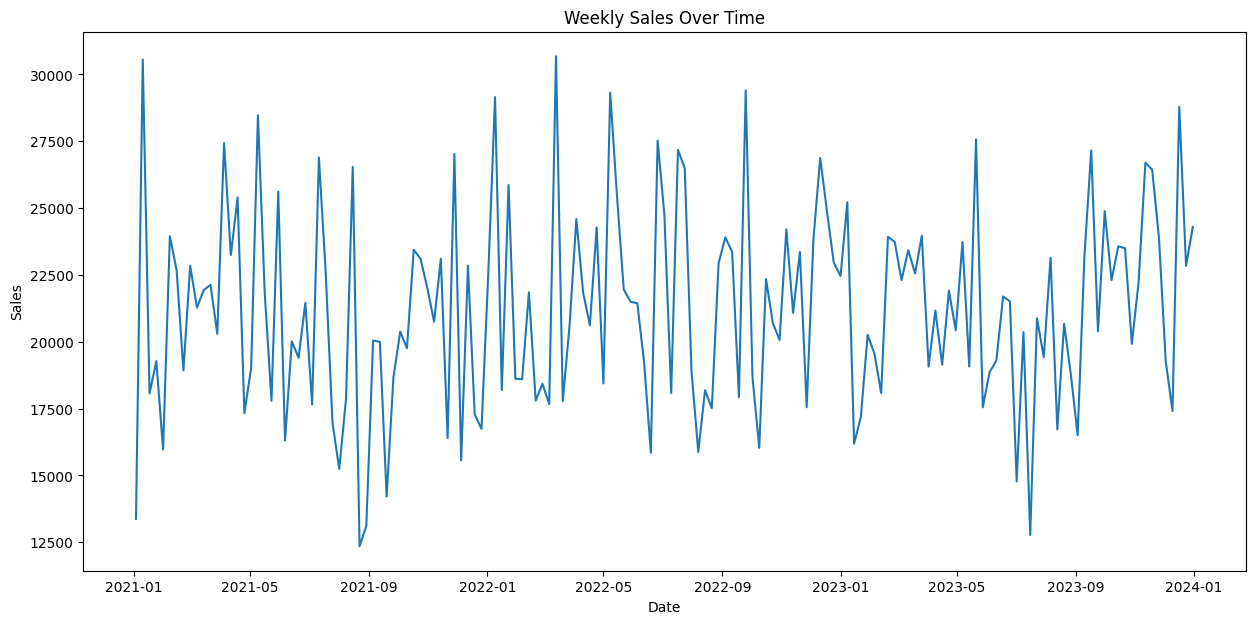

In [48]:
# Create a temporary variable for weekly sales without modifying df
weekly_sales = df['Sales'].resample('W').sum()

# Time series plot of weekly sales
plt.figure(figsize=(15, 7))
plt.plot(weekly_sales.index, weekly_sales)
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


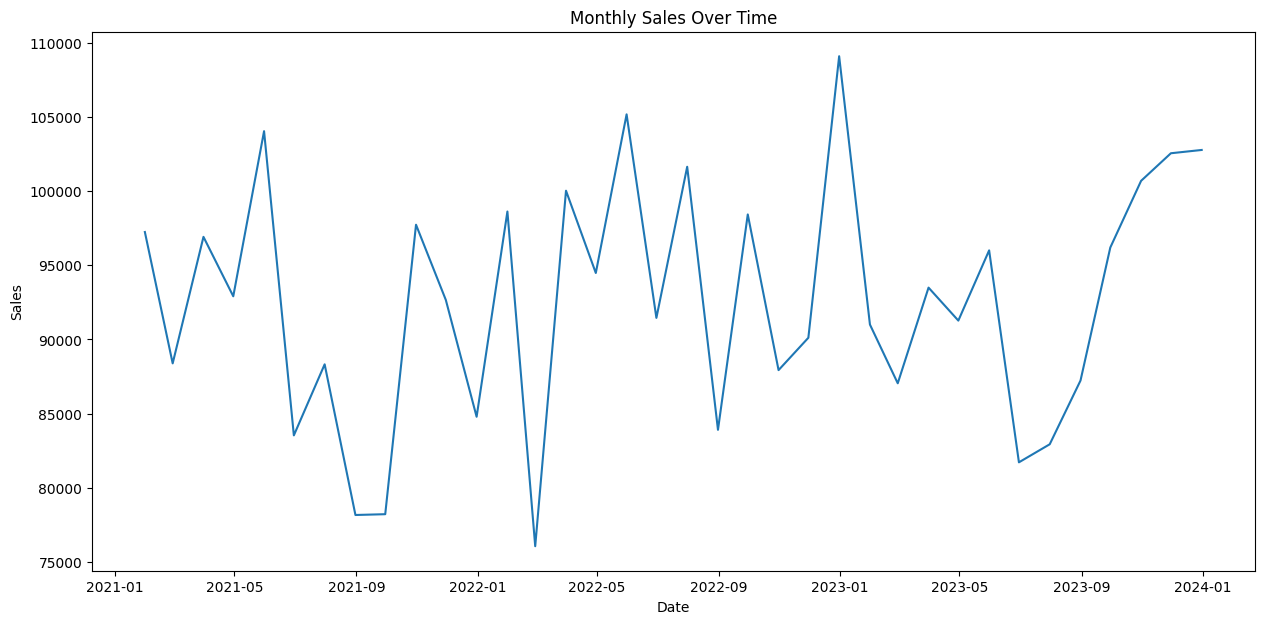

In [11]:
# Resample to monthly data for clearer trends
monthly_sales = df['Sales'].resample('M').sum()
# Monthly sales plot
plt.figure(figsize=(15, 7))
plt.plot(monthly_sales.index, monthly_sales)
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

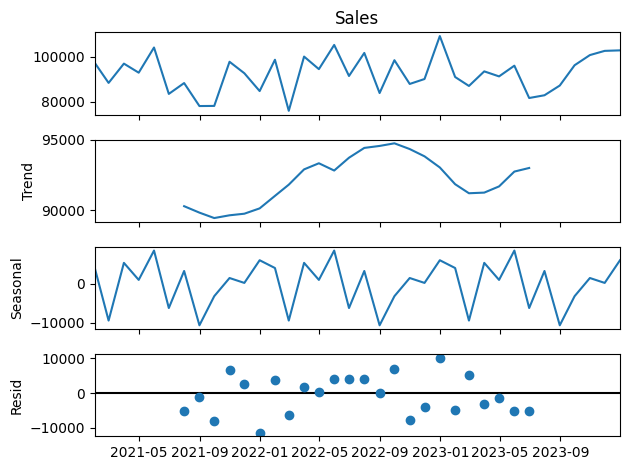

In [12]:

# 3. Seasonal Decomposition
result = seasonal_decompose(monthly_sales, model='additive')
result.plot()
plt.tight_layout()
plt.show()

In [15]:
print(len(monthly_sales))

36


/tmp/ipykernel_9757/2691619.py:16: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax1.stem(range(len(acf_values)), acf_values, use_line_collection=True)
/tmp/ipykernel_9757/2691619.py:25: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax2.stem(range(len(pacf_values)), pacf_values, use_line_collection=True)


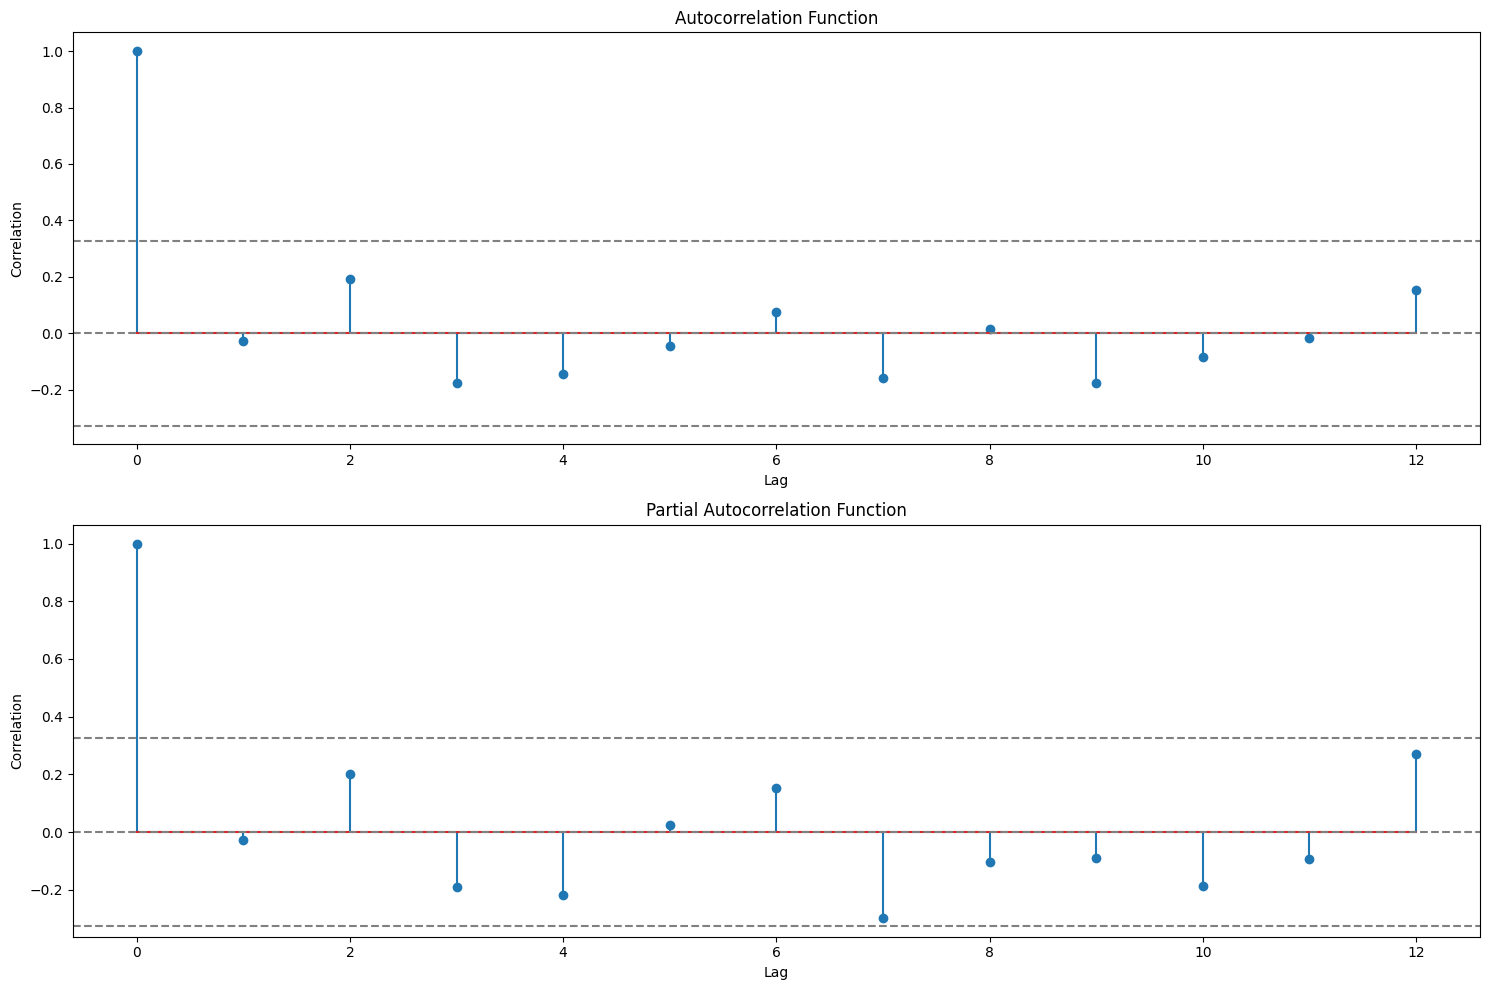

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf, pacf

# Determine number of lags (use 1/3 of data length)
n_lags = len(monthly_sales) // 3  # This will be 12

# Calculate ACF and PACF
acf_values = acf(monthly_sales.dropna(), nlags=n_lags)
pacf_values = pacf(monthly_sales.dropna(), nlags=n_lags)

# Plot ACF and PACF using stem plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot ACF
ax1.stem(range(len(acf_values)), acf_values, use_line_collection=True)
ax1.axhline(y=0, linestyle='--', color='gray')
ax1.axhline(y=-1.96/np.sqrt(len(monthly_sales)), linestyle='--', color='gray')
ax1.axhline(y=1.96/np.sqrt(len(monthly_sales)), linestyle='--', color='gray')
ax1.set_title('Autocorrelation Function')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Correlation')

# Plot PACF
ax2.stem(range(len(pacf_values)), pacf_values, use_line_collection=True)
ax2.axhline(y=0, linestyle='--', color='gray')
ax2.axhline(y=-1.96/np.sqrt(len(monthly_sales)), linestyle='--', color='gray')
ax2.axhline(y=1.96/np.sqrt(len(monthly_sales)), linestyle='--', color='gray')
ax2.set_title('Partial Autocorrelation Function')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Correlation')

plt.tight_layout()
plt.show()


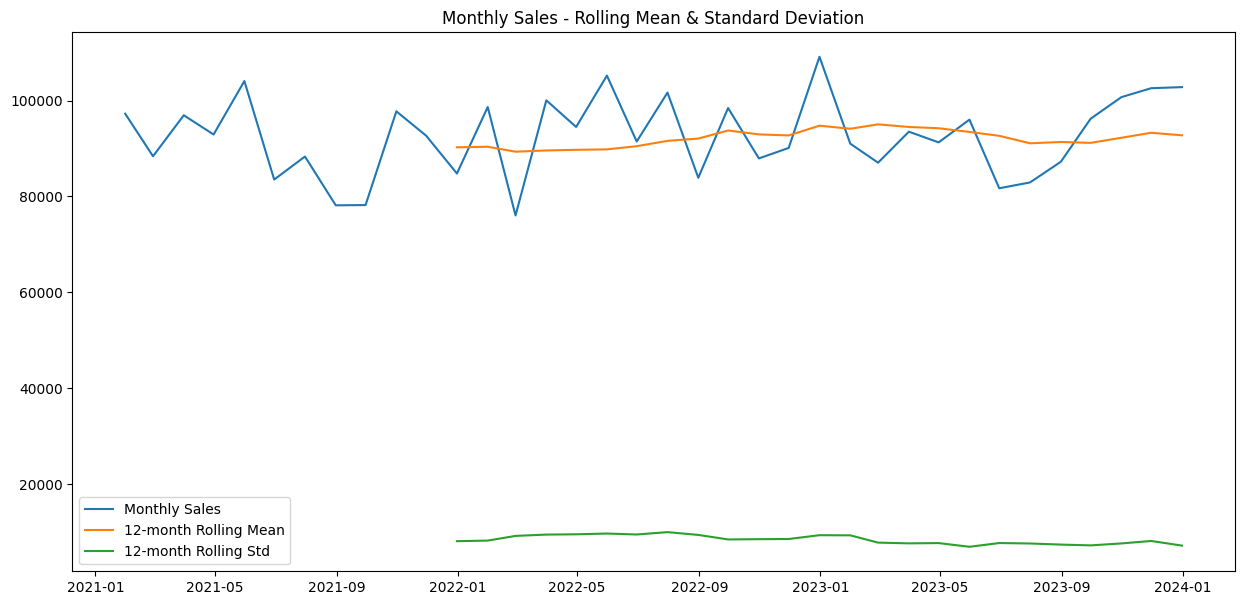

In [18]:
# 5. Rolling statistics
rolling_mean = monthly_sales.rolling(window=12).mean()
rolling_std = monthly_sales.rolling(window=12).std()

plt.figure(figsize=(15, 7))
plt.plot(monthly_sales.index, monthly_sales, label='Monthly Sales')
plt.plot(rolling_mean.index, rolling_mean, label='12-month Rolling Mean')
plt.plot(rolling_std.index, rolling_std, label='12-month Rolling Std')
plt.legend()
plt.title('Monthly Sales - Rolling Mean & Standard Deviation')
plt.show()

In [21]:
# # 6. Year-over-Year comparison
# df['Year'] = df.index.year
# df['Month'] = df.index.month

# yearly_monthly_sales = df.groupby(['Year', 'Month'])['Sales'].sum().unstack()
# yearly_monthly_sales.plot(figsize=(15, 7))
# plt.title('Monthly Sales by Year')
# plt.xlabel('Month')
# plt.ylabel('Sales')
# plt.legend(title='Year')
# plt.show()

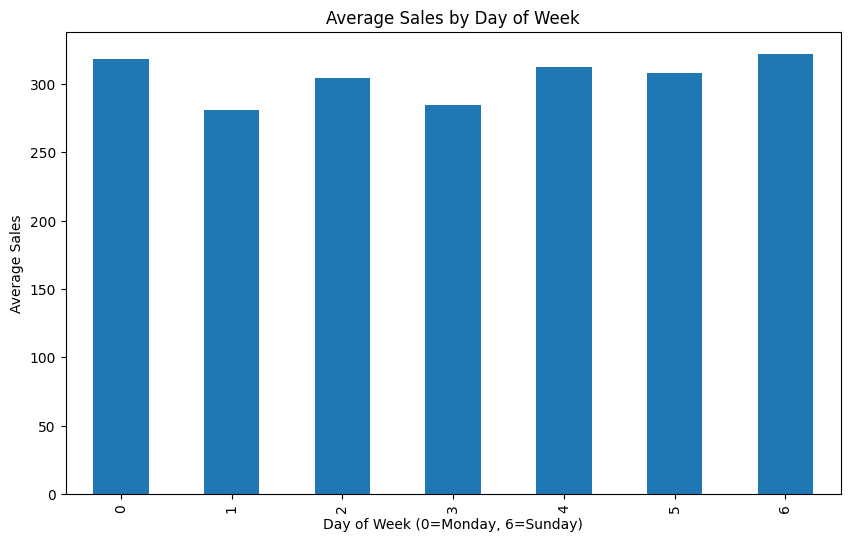

In [20]:
# 7. Day of week patterns
df['DayOfWeek'] = df.index.dayofweek
day_of_week_sales = df.groupby('DayOfWeek')['Sales'].mean()
day_of_week_sales.plot(kind='bar', figsize=(10, 6))
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Sales')
plt.show()

In [26]:
# Create is_holiday column using the holidays library (using US holidays as an example)
us_holidays = holidays.US()  # Change to the appropriate country if needed

# Function to check if a date is a holiday
def is_holiday(date):
    return date in us_holidays

# Apply the function to create the is_holiday column
df['is_holiday'] = df.index.to_series().apply(is_holiday).astype(int)

In [27]:
df

,Store,Store_Type,Store_Status,Promo,Promo2,School_Holiday,Customers,Sales,Year,Month,DayOfWeek,is_holiday
Date,,,,,,,,,,,,
2021-01-01,1,supermarket,1,0,0,0,124,0,2021,1,4,1
2021-01-02,1,pharmacy,1,0,0,0,87,0,2021,1,5,0
2021-01-03,1,supermarket,1,1,0,0,74,778,2021,1,6,0
2021-01-04,1,supermarket,0,1,0,0,0,0,2021,1,0,0
2021-01-05,1,pharmacy,1,1,0,0,76,1002,2021,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,10,pharmacy,1,0,1,0,112,28,2023,12,2,0
2023-12-28,10,convenience,1,0,0,0,111,55,2023,12,3,0
2023-12-29,10,convenience,1,0,0,0,99,0,2023,12,4,0


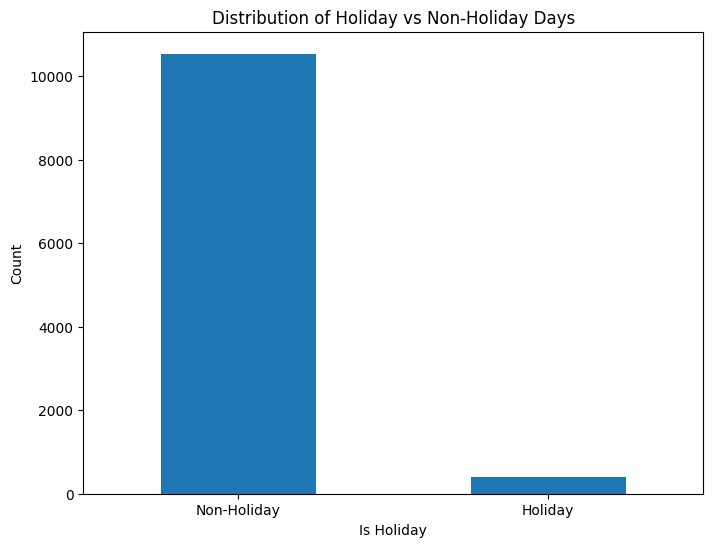

In [28]:

# Visualize distribution of is_holiday
plt.figure(figsize=(8, 6))
df['is_holiday'].value_counts().plot(kind='bar')
plt.title('Distribution of Holiday vs Non-Holiday Days')
plt.xlabel('Is Holiday')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'], rotation=0)
plt.show()


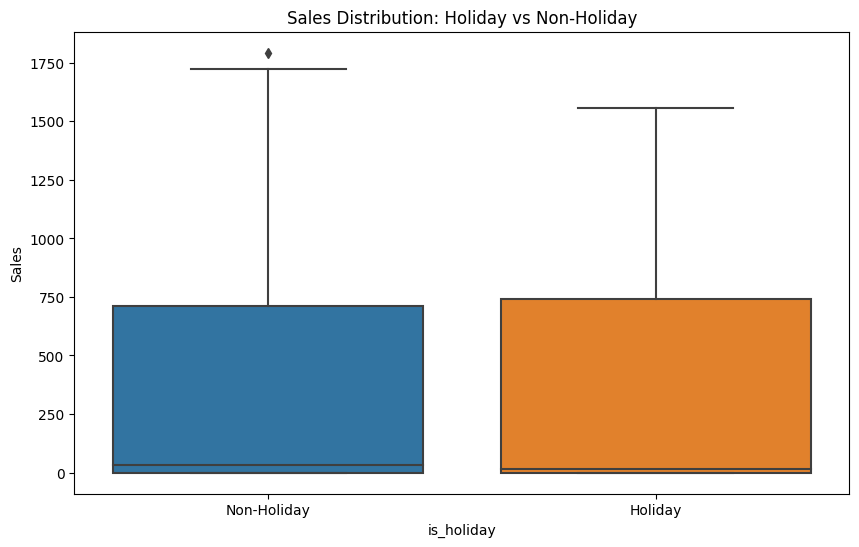

In [32]:

# Visualize sales distribution for holiday vs non-holiday
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_holiday', y='Sales', data=df)
plt.title('Sales Distribution: Holiday vs Non-Holiday')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()

In [34]:
# Print summary statistics
print(df.groupby('DayOfWeek')['Sales'].describe())
print("\nHoliday vs Non-Holiday Sales:")
print(df.groupby('is_holiday')['Sales'].describe())

# Print the list of holidays in the dataset
holiday_dates = df[df['is_holiday'] == 1].index.tolist()
print("\nHolidays in the dataset:")
for date in holiday_dates:
    print(f"{date.date()}: {us_holidays.get(date)}")

            count        mean         std  min  25%   50%     75%     max
DayOfWeek                                                                
0          1560.0  318.338462  469.388808  0.0  0.0  34.0  770.50  1639.0
1          1560.0  280.810256  443.543271  0.0  0.0  30.5  291.00  1691.0
2          1560.0  304.339744  462.794149  0.0  0.0  28.0  725.00  1603.0
3          1560.0  284.910897  454.747902  0.0  0.0  23.5  322.25  1793.0
4          1570.0  312.052229  465.506055  0.0  0.0  37.5  742.00  1621.0
5          1570.0  307.989172  469.064582  0.0  0.0  37.5  705.75  1721.0
6          1570.0  321.981529  466.041927  0.0  0.0  43.0  790.00  1697.0

Holiday vs Non-Holiday Sales:
              count        mean         std  min  25%   50%     75%     max
is_holiday                                                                 
0           10540.0  304.158824  461.256830  0.0  0.0  34.0  713.25  1793.0
1             410.0  309.865854  475.748371  0.0  0.0  16.5  742.25  1557.0

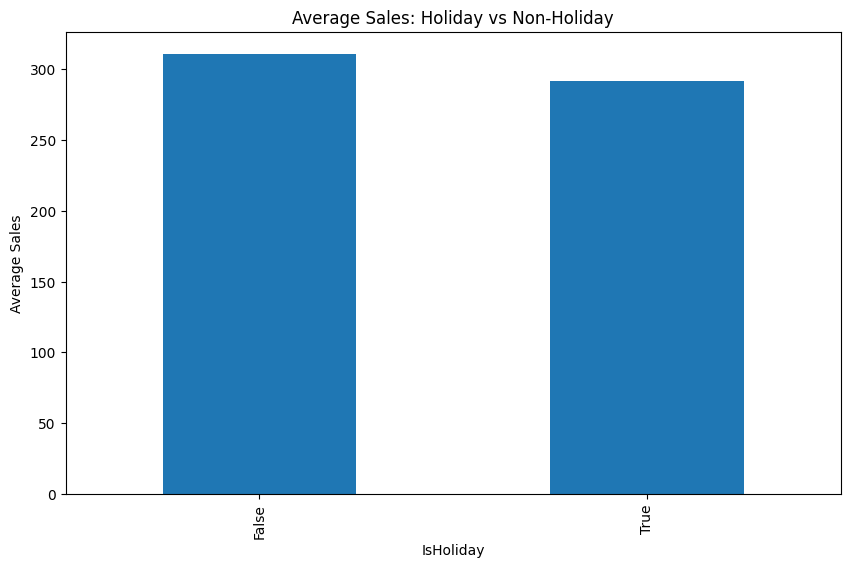

In [35]:
# 8. Checking for holidays effect
df['IsHoliday'] = df['School_Holiday'] | (df.index.month == 12)  # Assuming December is a holiday month
holiday_effect = df.groupby('IsHoliday')['Sales'].mean()
holiday_effect.plot(kind='bar', figsize=(10, 6))
plt.title('Average Sales: Holiday vs Non-Holiday')
plt.ylabel('Average Sales')
plt.show()


Monthly Average Sales: Promo vs No Promo
          No Promo        Promo
Date                           
2021-01  34.630137   985.362637
2021-02  28.096939   986.630952
2021-03  34.088372   943.115789
2021-04  31.838095   958.077778
2021-05  40.755760  1023.817204
2021-06  36.028037   881.558140
2021-07  40.277512   791.108911
2021-08  32.000000   864.060976
2021-09  38.575893   915.289474
2021-10  29.728111   981.645161
2021-11  30.840580   927.763441
2021-12  34.017937   887.287356
2022-01  40.640553   965.774194
2022-02  34.883495   930.472973
2022-03  29.212264   957.632653
2022-04  27.779817  1078.414634
2022-05  32.724138   921.037383
2022-06  36.848780   883.157895
2022-07  36.201005   850.918919
2022-08  41.195455   831.511111
2022-09  37.809524  1005.522222
2022-10  30.573991   932.310345
2022-11  38.633028   996.231707
2022-12  41.415459   976.174757
2023-01  37.336323   950.333333
2023-02  42.092308   927.435294
2023-03  34.977064   933.402174
2023-04  31.430622   930.802198

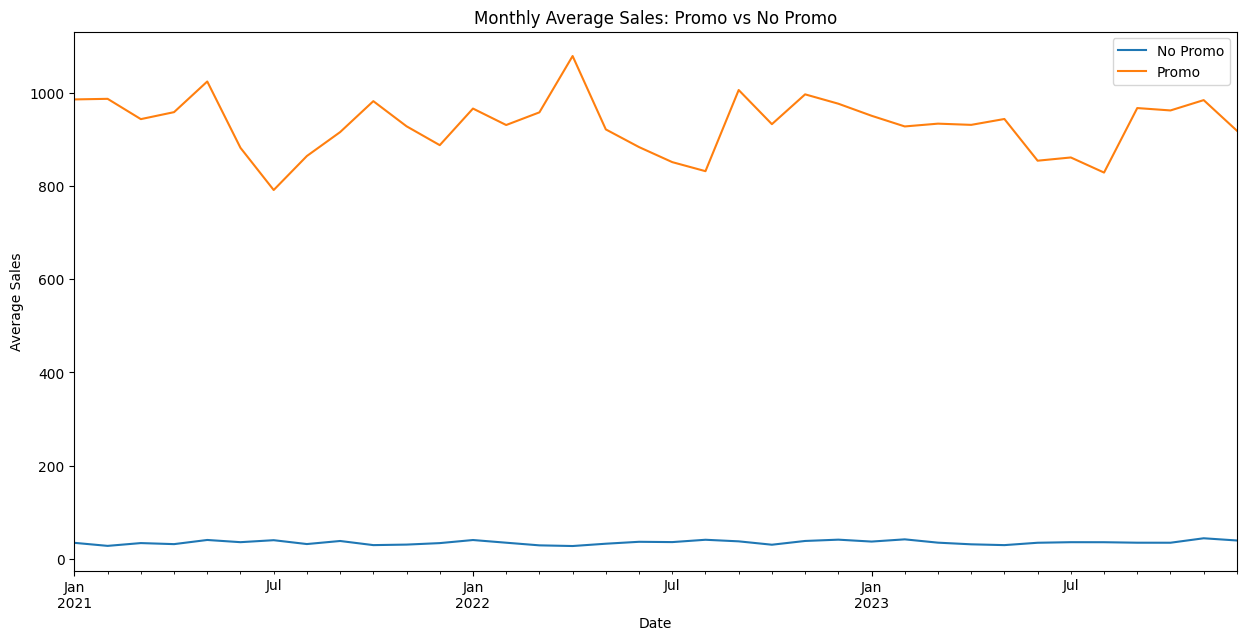

In [38]:
# 9. Promo effect over time
monthly_promo_sales = df.groupby([df.index.to_period('M'), 'Promo'])['Sales'].mean().unstack()

# Rename columns for clarity
monthly_promo_sales.columns = ['No Promo', 'Promo']

# Display the data
print("Monthly Average Sales: Promo vs No Promo")
print(monthly_promo_sales)

# Calculate the difference and percentage increase
monthly_promo_sales['Difference'] = monthly_promo_sales['Promo'] - monthly_promo_sales['No Promo']
monthly_promo_sales['Percentage Increase'] = (monthly_promo_sales['Difference'] / monthly_promo_sales['No Promo']) * 100

print("\nDifference and Percentage Increase:")
print(monthly_promo_sales[['Difference', 'Percentage Increase']])

# Plot
monthly_promo_sales[['No Promo', 'Promo']].plot(figsize=(15, 7))
plt.title('Monthly Average Sales: Promo vs No Promo')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.legend(['No Promo', 'Promo'])
plt.show()

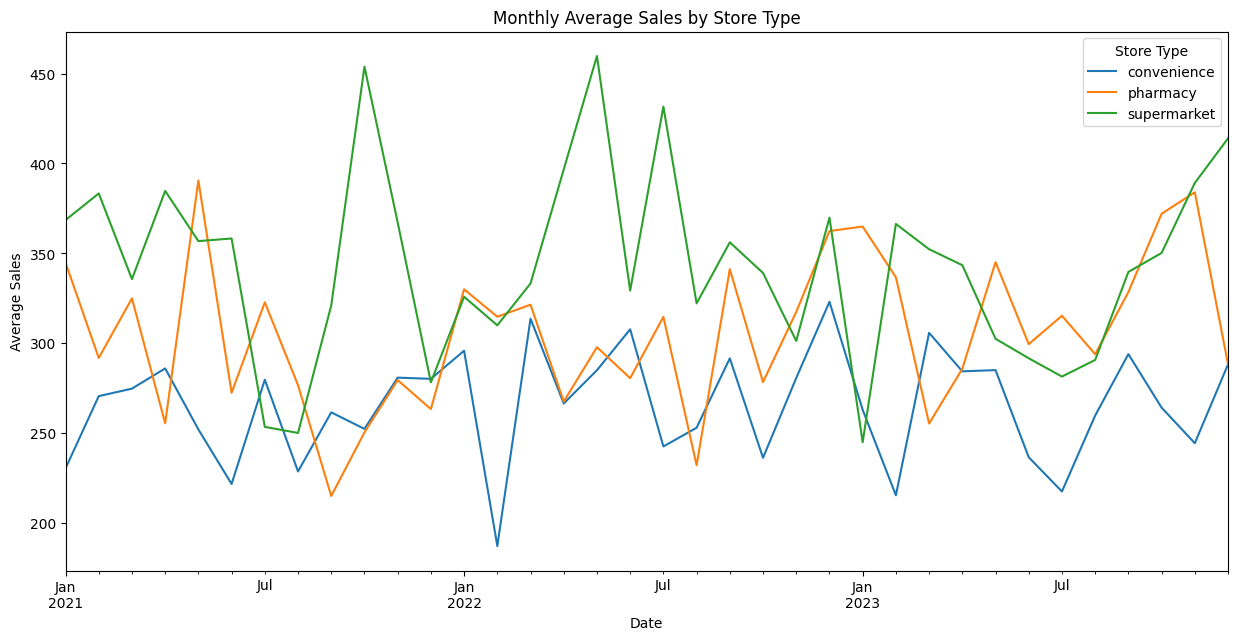

In [39]:
# 10. Store type performance over time
store_type_sales = df.groupby([df.index.to_period('M'), 'Store_Type'])['Sales'].mean().unstack()
store_type_sales.plot(figsize=(15, 7))
plt.title('Monthly Average Sales by Store Type')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.legend(title='Store Type')
plt.show()

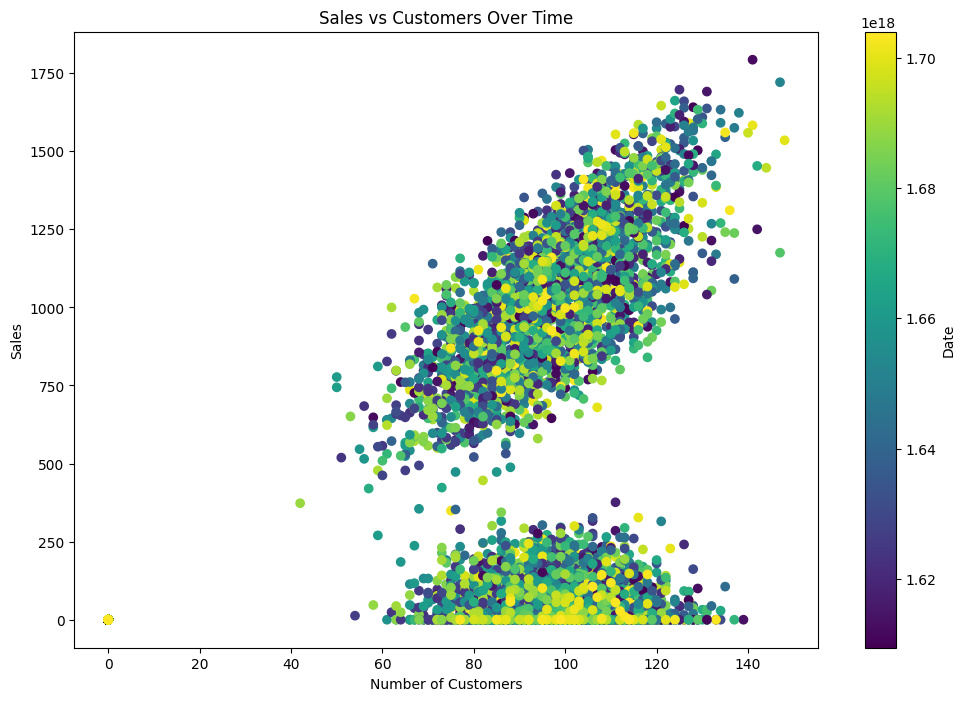

In [41]:
# 12. Sales vs Customers scatter plot with time color gradient
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['Customers'], df['Sales'], c=df.index, cmap='viridis')
plt.colorbar(scatter, label='Date')
plt.title('Sales vs Customers Over Time')
plt.xlabel('Number of Customers')
plt.ylabel('Sales')
plt.show()

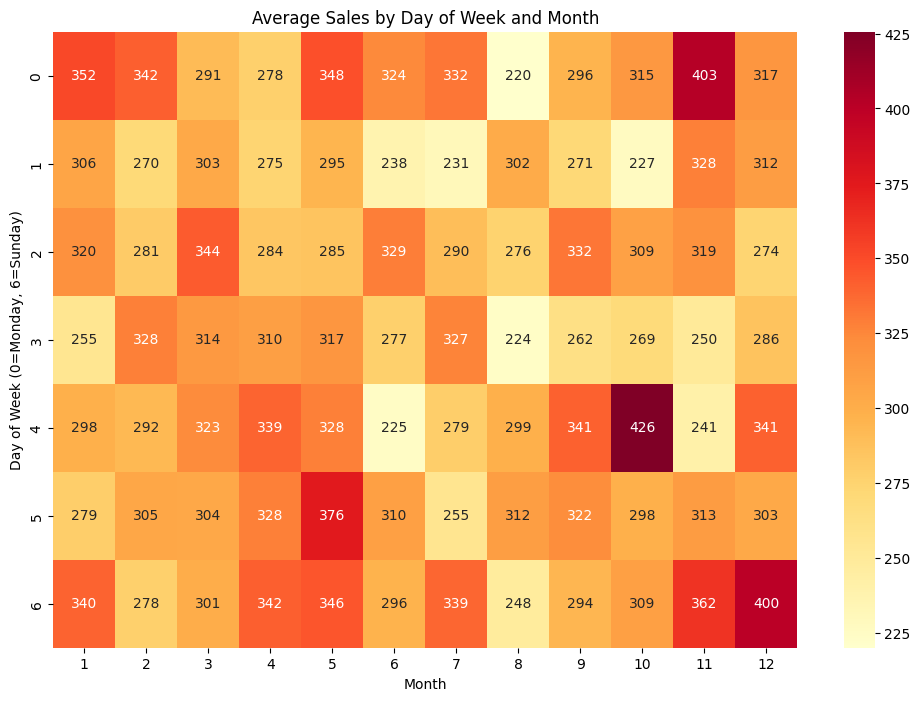

In [42]:
# 13. Heatmap of sales by day of week and month
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
sales_heatmap = df.pivot_table(values='Sales', index='DayOfWeek', columns='Month', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(sales_heatmap, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Average Sales by Day of Week and Month')
plt.xlabel('Month')
plt.ylabel('Day of Week (0=Monday, 6=Sunday)')
plt.show()

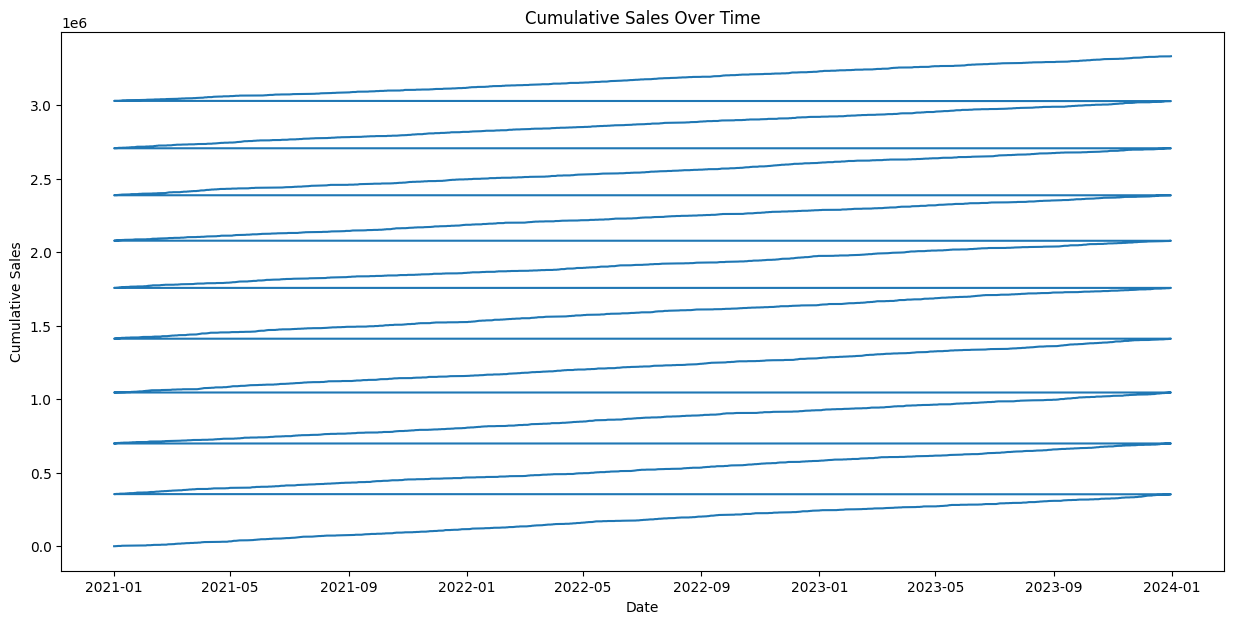

In [43]:
# 14. Cumulative sales
df['CumulativeSales'] = df['Sales'].cumsum()
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['CumulativeSales'])
plt.title('Cumulative Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Sales')
plt.show()

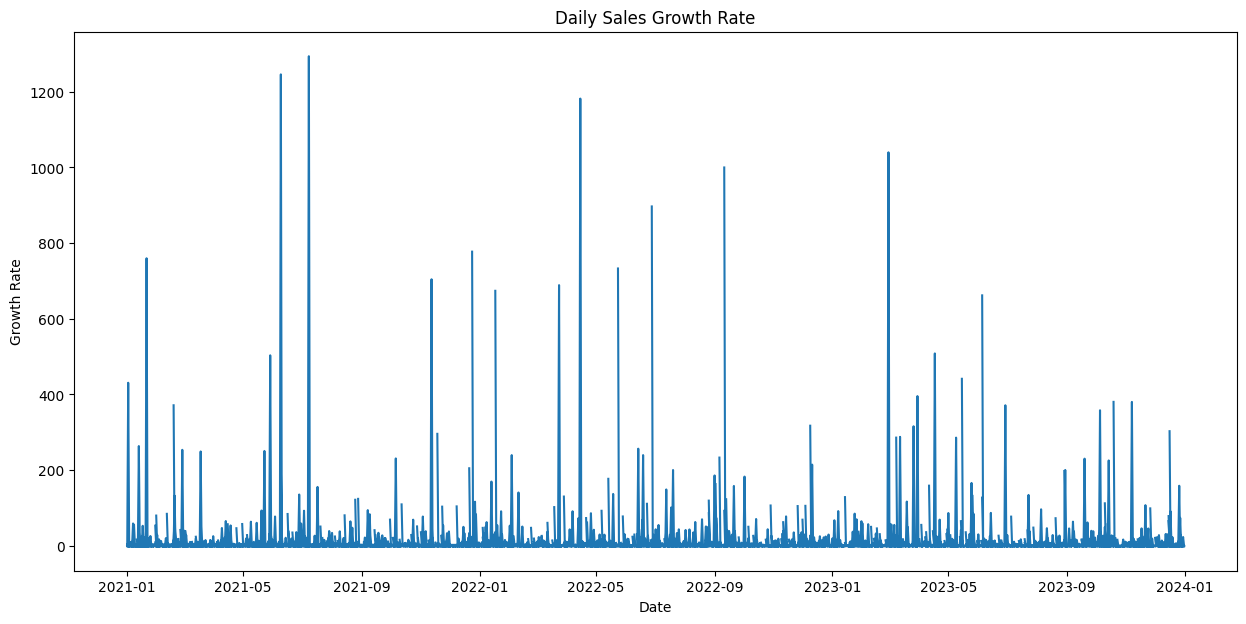

In [44]:
# 15. Sales growth rate
df['SalesGrowthRate'] = df['Sales'].pct_change()
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['SalesGrowthRate'])
plt.title('Daily Sales Growth Rate')
plt.xlabel('Date')
plt.ylabel('Growth Rate')
plt.show()

In [52]:
# # 16. Moving average and standard deviation
# window = 30  # 30-day window
# df['MA30'] = df['Sales'].rolling(window=window).mean()
# df['SD30'] = df['Sales'].rolling(window=window).std()

# plt.figure(figsize=(15, 7))
# plt.plot(df.index, df['Sales'], label='Daily Sales')
# plt.plot(df.index, df['MA30'], label=f'{window}-day Moving Average')
# plt.fill_between(df.index, df['MA30'] - df['SD30'], df['MA30'] + df['SD30'], alpha=0.2)
# plt.title(f'Daily Sales with {window}-day Moving Average and Standard Deviation')
# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.legend()
# plt.show()

In [55]:
features_to_remove = ['MA30', 'SD30', 'SalesGrowthRate','IsHoliday','CumulativeSales']
df_cleaned = df.drop(columns=features_to_remove, errors='ignore')

In [56]:
df_cleaned

,Store,Store_Type,Store_Status,Promo,Promo2,School_Holiday,Customers,Sales,Year,Month,DayOfWeek,is_holiday
Date,,,,,,,,,,,,
2021-01-01,1,supermarket,1,0,0,0,124,0,2021,1,4,1
2021-01-02,1,pharmacy,1,0,0,0,87,0,2021,1,5,0
2021-01-03,1,supermarket,1,1,0,0,74,778,2021,1,6,0
2021-01-04,1,supermarket,0,1,0,0,0,0,2021,1,0,0
2021-01-05,1,pharmacy,1,1,0,0,76,1002,2021,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,10,pharmacy,1,0,1,0,112,28,2023,12,2,0
2023-12-28,10,convenience,1,0,0,0,111,55,2023,12,3,0
2023-12-29,10,convenience,1,0,0,0,99,0,2023,12,4,0


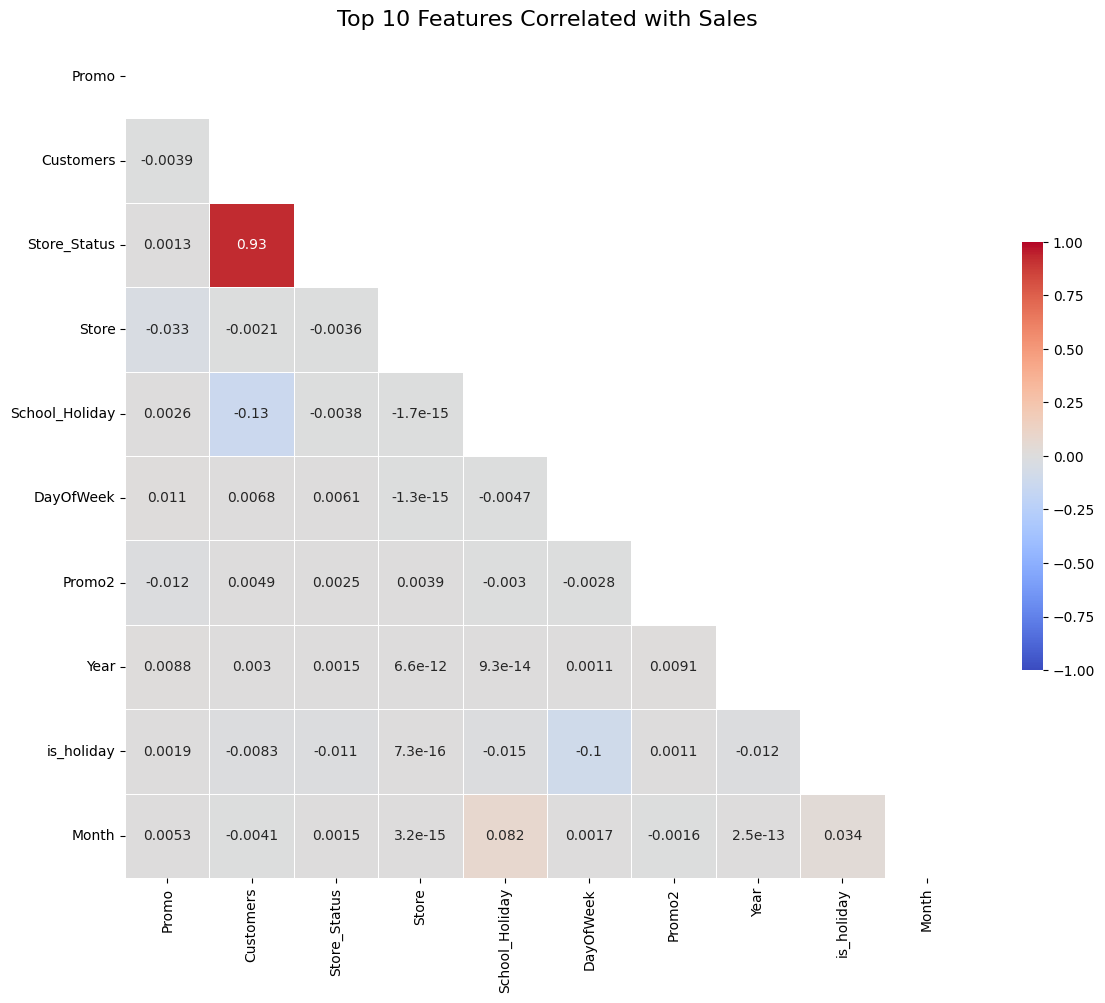

Correlations with Sales:
Promo             0.888812
Customers         0.243039
Store_Status      0.220830
Store             0.032167
School_Holiday    0.027882
DayOfWeek         0.011325
Promo2            0.008017
Year              0.007275
is_holiday        0.002346
Month             0.000853
Name: Sales, dtype: float64


In [57]:
# Assuming df is your DataFrame
# Select numeric columns for correlation analysis
numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlations
correlations = df_cleaned[numeric_columns].corr()['Sales'].abs().sort_values(ascending=False)

# Select top 10 correlated features (excluding 'Sales' itself)
top_features = correlations[1:11].index.tolist()

# Create correlation matrix for these features
f_correlation = df[top_features].corr()

# Generate a mask for the upper triangle
f_mask = np.triu(np.ones_like(f_correlation, dtype=bool))

# Set up the matplotlib figure
f_fig, f_ax = plt.subplots(figsize=(12, 10))

# Create the heatmap
sns.heatmap(f_correlation, mask=f_mask, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Top 10 Features Correlated with Sales', fontsize=16)
plt.tight_layout()
plt.show()

# Print the correlation values
print("Correlations with Sales:")
print(correlations[top_features])
